# TE 300B
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission either individually or in teams of 3 or 4 members, and most be presented at the end of the correspoding.  While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. 

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Submission

Show this Jupyter Notebook to your professor with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [199]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [201]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [202]:

y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

Label_Encoder= LabelEncoder()
y_train = Label_Encoder.fit_transform(y_train)
y_val = Label_Encoder.fit_transform(y_val)



In [203]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    # Si shuffle es True, se reordenan los datos
    if shuffle:
        idx = np.random.permutation(len(x))  # Genera una permutación aleatoria de los índices
        x = x[idx]  # Reordena x con los índices aleatorios
        y = y[idx]  # Reordena y con los índices aleatorios

    # Calcula el índice donde se dividirán los datos
    split_idx = int(len(x) * (pct))

    # Divide los datos en dos partes en el índice calculado
    x_val = x[:split_idx]  # Los primeros 'split_idx' elementos se usan para la validación
    y_val = y[:split_idx]  # Los primeros 'split_idx' elementos se usan para la validación
    x_test = x[split_idx:]  # Los elementos restantes se usan para la prueba
    y_test = y[split_idx:]  # Los elementos restantes se usan para la prueba

    # Devuelve los conjuntos de validación y prueba
    return x_val, y_val, x_test, y_test

In [204]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [205]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [206]:
def normalize_data(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [207]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalize_data(x_mean, x_std, x_train)
x_val = normalize_data(x_mean, x_std, x_val)
x_test = normalize_data(x_mean, x_std, x_test)

In [208]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Graficar muestras


- Crea una nueva figura con un tamaño de 5x5 pulgadas.
- Muestra la imagen propocionada. 'squeeze()' se usa para eliminar las dimensiones de tamaño uno de la imagen. 'cmap=plt.get('gray')' se usa para mostrar la imagen en escala de grises.
- Desactiva los ejes de la figura.
- muestra la figura.


In [209]:
def plot_samples(x_data, y_data, num_samples=24):
 # Select random indices to plot
    idx = np.random.randint(len(y_data))

    # Plot the samples
    plt.figure(figsize=(15, 5))
    plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {alphabet[y_data[idx]]}')
    plt.axis('off')
    plt.show()

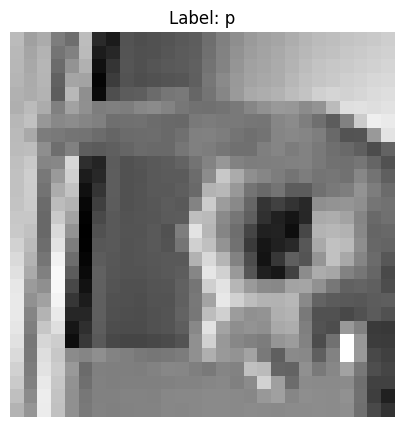

In [210]:
plot_samples(x_test, y_test)

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [211]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras' # Aseguramos que la cantidad de muestras sea la misma
    total_data = x.shape[0] # Obtenemos la cantidad de muestras
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [212]:
class np_tensor(np.ndarray): pass

###  Clase Linear

In [213]:
class Linear(): # Clase para definir una capa lineal
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) /np.sqrt(input_size/2)).view(np_tensor) # Inicializamos los pesos de forma aleatoria
        self.b = np.zeros((output_size, 1)).view(np_tensor) # Inicializamos los bias en 0
        
    def __call__(self, X): # esta el foward de la clase lineal
        Z= self.W @ X + self.b # Multiplicamos los pesos por la entrada y le sumamos el bias
        return Z
        
    def backward(self, X, Z): # esta es la parte de backpropagation
        
        # Calculamos el gradiente de la entrada,
        # la Matriz de pesos transpuesta por el gradiente de la salida
        X.grad = self.W.T @ Z.grad 
        
        # Calculamos el gradiente de los pesos, el gradiente 
        # de la salida por la entrada transpuesta
        self.W.grad = Z.grad @ X.T 
        
        # Calculamos el gradiente del bias, 
        # sumamos el gradiente de la salida
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True) 
        

### Clase ReLU

In [214]:
class ReLU(): # Clase para la función de activación ReLU, debe regresar el calor maximo entre 0 y el valor de Z
    def __call__(self, Z):
        return np.maximum(0, Z) # Regresamos el valor maximo entre 0 y Z
    
    def backward(self, Z, A):
        Z.grad = A.grad.copy() # Copiamos el gradiente de A a Z
        Z.grad[Z < 0] = 0 # Si Z es menor a 0, el gradiente es 0
        return Z.grad

### Clase Sequential

In [215]:
class Sequential_layers():
    def __init__(self, layers): # Inicializamos las capas
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X): # Forward de la red
        self.x = X
        self.outputs['l0'] = self.x #El diccionario tien como llave L0
        for i, layer in enumerate(self.layers,1):
          self.x=layer(self.x)
          self.outputs['l'+str(i)] = self.x
        return self.x # La salida de la ultima capa.

    def backward(self):
        for i in reversed(range(len(self.layers))):
          self.layers[i].backward(self.outputs['l' + str(i)], self.outputs['l' + str(i + 1)])

    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
          if isinstance(layer, ReLU): continue
          layer.W = layer.W - learning_rate * layer.W.grad
          layer.b = layer.b - learning_rate * layer.b.grad

    # Predicts the image
    def predict(self, X):
        return np.argmax(self(X))

### Cost Function

In [216]:
# Scores if the entry for softmax
def softmaxXEntropy(x, y):
  # Softmax
  exp_scores = np.exp(x)
  sum_exp_scores = np.sum(exp_scores, axis = 0, keepdims = True)
  probs = exp_scores/sum_exp_scores

  # XEntropy
  y_hat = probs[y.squeeze(), np.arange(x.shape[1])]
  cost = np.mean(-np.log(y_hat))
  probs[y.squeeze(), np.arange(x.shape[1])] -= 1

  x.grad = probs
  return probs, cost
  
  

### Loop de entrenamiento

In [217]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3): # Función para entrenar el modelo
    for epoch in range(epochs): # Recorremos las épocas
        for i,(x,y) in enumerate(create_minibatches(mb_size, x_train, y_train)): # Recorremos los minibatches
            y=y.reshape(-1,1)
            scores = model(x.T.view(np_tensor)) # Obtenemos los scores
            _,cost = softmaxXEntropy(scores, y) # Calculamos el costo
            model.backward() # Backpropagation
            model.update(learning_rate) # Actualizamos los pesos
            
        print(f'Epoch: {epoch} - Costo: {cost.mean()}') # Imprimimos el costo

In [218]:
def accuracy(model,x, y, mb_size): # Función para calcular la precisión del modelo
    correct = 0
    total = 0
    for i, (x,y) in enumerate (create_minibatches(mb_size, x, y)): # Recorremos los minibatches
        pred = model(x.T.view(np_tensor)) # Obtenemos las predicciones
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze()) # Sumamos las predicciones correctas
        total += pred.shape[1] # Sumamos el total de predicciones
    return correct/total

### Create your model and train it

In [228]:

model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 24)])
mb_size = 128
learning_rate = 1e-3
epochs = 20

In [229]:
train(model, epochs, mb_size, learning_rate)

Epoch: 0 - Costo: 0.050419157355705436
Epoch: 1 - Costo: 0.014802302850579853
Epoch: 2 - Costo: 0.007665945673743035
Epoch: 3 - Costo: 0.005008381989127569
Epoch: 4 - Costo: 0.004759288912630424
Epoch: 5 - Costo: 0.003152824558050127
Epoch: 6 - Costo: 0.0024967489275462803
Epoch: 7 - Costo: 0.0029260424468392394
Epoch: 8 - Costo: 0.002424909223664339
Epoch: 9 - Costo: 0.002139206522655634
Epoch: 10 - Costo: 0.0014429727234806832
Epoch: 11 - Costo: 0.0011480272237656235
Epoch: 12 - Costo: 0.0012839533446975919
Epoch: 13 - Costo: 0.0008552521232361641
Epoch: 14 - Costo: 0.0008230789167156617
Epoch: 15 - Costo: 0.0011305096070649264
Epoch: 16 - Costo: 0.001216406798877986
Epoch: 17 - Costo: 0.0010324664615788126
Epoch: 18 - Costo: 0.0005704824660922935
Epoch: 19 - Costo: 0.0005903191773758438


### Test your model on Random data from your test set

In [231]:
print(accuracy(model, x_test, y_test, mb_size))


0.7986614612381484


In [221]:
idx = np.random.randint(len(y_test))
plot_samples(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

TypeError: plot_samples() missing 1 required positional argument: 'y_data'